In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasdaq-daily-stock-prices/LICN.csv
/kaggle/input/nasdaq-daily-stock-prices/MGRM.csv
/kaggle/input/nasdaq-daily-stock-prices/LAB.csv
/kaggle/input/nasdaq-daily-stock-prices/ISRL.csv
/kaggle/input/nasdaq-daily-stock-prices/AMSF.csv
/kaggle/input/nasdaq-daily-stock-prices/DFLI.csv
/kaggle/input/nasdaq-daily-stock-prices/ACRV.csv
/kaggle/input/nasdaq-daily-stock-prices/AKU.csv
/kaggle/input/nasdaq-daily-stock-prices/MDXH.csv
/kaggle/input/nasdaq-daily-stock-prices/UTSI.csv
/kaggle/input/nasdaq-daily-stock-prices/UFCS.csv
/kaggle/input/nasdaq-daily-stock-prices/ZM.csv
/kaggle/input/nasdaq-daily-stock-prices/DCPH.csv
/kaggle/input/nasdaq-daily-stock-prices/HALL.csv
/kaggle/input/nasdaq-daily-stock-prices/OSIS.csv
/kaggle/input/nasdaq-daily-stock-prices/TCBC.csv
/kaggle/input/nasdaq-daily-stock-prices/RSSS.csv
/kaggle/input/nasdaq-daily-stock-prices/CRVL.csv
/kaggle/input/nasdaq-daily-stock-prices/BZFD.csv
/kaggle/input/nasdaq-daily-stock-prices/TBNK.csv
/kaggle/input/nasdaq-dai

In [2]:

import tensorflow as tf
from tensorflow.keras.layers import LSTMCell
tf.compat.v1.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
data = pd.read_csv('/kaggle/input/nasdaq-daily-stock-prices/IKNA.csv')
data.head()

,ticker,date,open,high,low,close
0,IKNA,2021-03-26,22.40,37.61,19.01,32.00
1,IKNA,2021-03-29,28.25,33.69,24.52,28.30
2,IKNA,2021-03-30,28.80,30.24,23.81,25.60
3,IKNA,2021-03-31,25.01,28.68,24.38,28.25
4,IKNA,2021-04-01,27.01,27.01,23.18,26.00


In [4]:
df=data.copy()

In [5]:
df.drop(['ticker'],axis=1)

,date,open,high,low,close
0,2021-03-26,22.40,37.610,19.01,32.00
1,2021-03-29,28.25,33.690,24.52,28.30
2,2021-03-30,28.80,30.240,23.81,25.60
3,2021-03-31,25.01,28.680,24.38,28.25
4,2021-04-01,27.01,27.010,23.18,26.00
...,...,...,...,...,...
572,2023-07-06,6.34,6.730,5.83,6.34
573,2023-07-07,6.50,6.725,6.26,6.37
574,2023-07-10,6.74,6.790,6.03,6.12
575,2023-07-11,6.26,6.565,6.02,6.27


In [6]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.755979
1,1.000000
2,0.968556
3,0.993800
4,0.940655


In [7]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((577, 6), (547, 1), (30, 1))

In [8]:
import tensorflow as tf
from tensorflow import keras
tf.compat.v1.disable_eager_execution()

In [9]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.compat.v1.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.compat.v1.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [10]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [11]:
def forecast():
    tf.compat.v1.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 1]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [12]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


/tmp/ipykernel_20/2288519239.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/tmp/ipykernel_20/2288519239.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
train loop: 100%|██████████| 300/300 [02:40<00:00,  1.87it/s, acc=97.9, cost=0.0011]


simulation 2


/tmp/ipykernel_20/2288519239.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/tmp/ipykernel_20/2288519239.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/opt/conda/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [02:41<00:00,  1.86it/s, acc=97.6, cost=0.00125

simulation 3


/tmp/ipykernel_20/2288519239.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/tmp/ipykernel_20/2288519239.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/opt/conda/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [02:44<00:00,  1.82it/s, acc=97.2, cost=0.00187

simulation 4


/tmp/ipykernel_20/2288519239.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/tmp/ipykernel_20/2288519239.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/opt/conda/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [02:44<00:00,  1.82it/s, acc=97.7, cost=0.00122

simulation 5


/tmp/ipykernel_20/2288519239.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/tmp/ipykernel_20/2288519239.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/opt/conda/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [02:43<00:00,  1.84it/s, acc=97.1, cost=0.00163

simulation 6


/tmp/ipykernel_20/2288519239.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/tmp/ipykernel_20/2288519239.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/opt/conda/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [02:44<00:00,  1.83it/s, acc=97.7, cost=0.0012]

simulation 7


/tmp/ipykernel_20/2288519239.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/tmp/ipykernel_20/2288519239.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/opt/conda/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [02:45<00:00,  1.81it/s, acc=97.8, cost=0.00112

simulation 8


/tmp/ipykernel_20/2288519239.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/tmp/ipykernel_20/2288519239.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/opt/conda/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [02:43<00:00,  1.83it/s, acc=97.5, cost=0.00161

simulation 9


/tmp/ipykernel_20/2288519239.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/tmp/ipykernel_20/2288519239.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/opt/conda/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [02:43<00:00,  1.83it/s, acc=97.7, cost=0.00127

simulation 10


/tmp/ipykernel_20/2288519239.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/tmp/ipykernel_20/2288519239.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/opt/conda/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [02:47<00:00,  1.79it/s, acc=97, cost=0.00192]


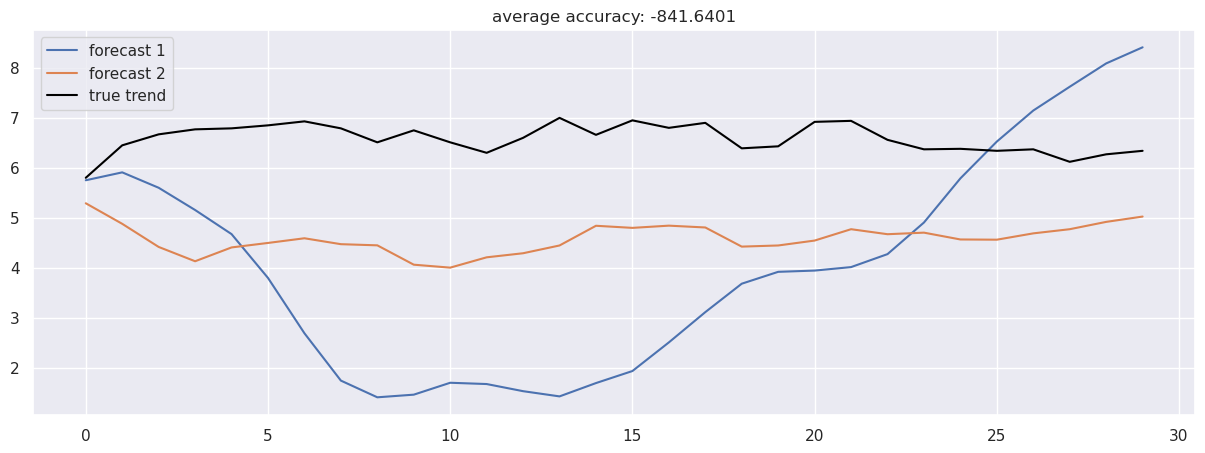

In [13]:
accuracies = [calculate_accuracy(df['close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results[:2]):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()

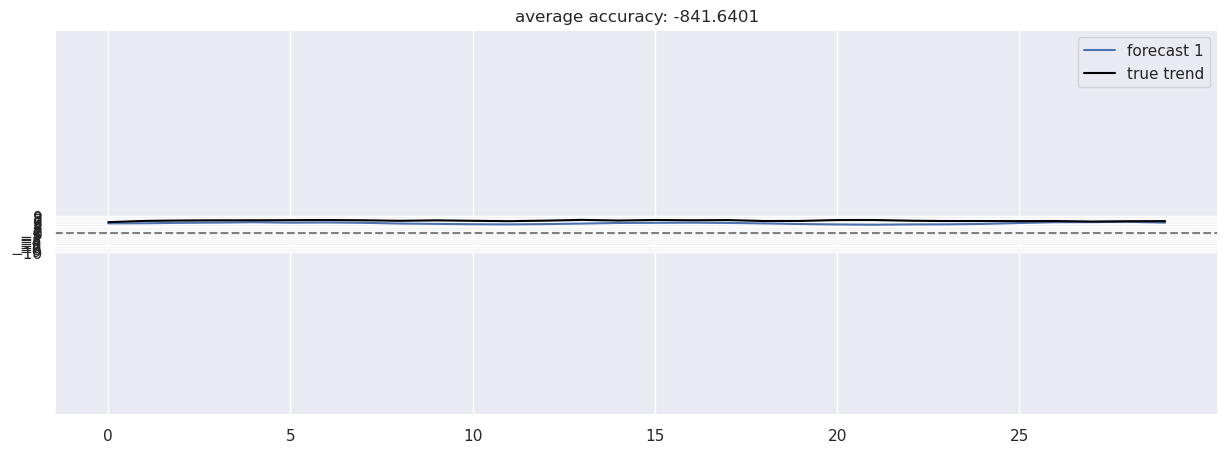

In [14]:
accuracies = [calculate_accuracy(df['close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize=(15, 5))
for no, r in enumerate(results[2:3]):  # Update to select simulations 1, 2, 3, and 4
    plt.plot(r, label='forecast %d' % (no + 1))
plt.plot(df['close'].iloc[-test_size:].values, label='true trend', c='black')
plt.axhline(y=0, color='gray', linestyle='--')  # Add a horizontal line at y=0
plt.legend()
plt.title('average accuracy: %.4f' % (np.mean(accuracies)))

plt.ylim(min(np.min(results[2:3]), np.min(df['close'].iloc[-test_size:].values)) - 100,
         max(np.max(results[2:3]), np.max(df['close'].iloc[-test_size:].values)) + 100)

plt.ylim(min(np.min(results[2:3]), np.min(df['close'].iloc[-test_size:].values)) - 100,
         max(np.max(results[2:3]), np.max(df['close'].iloc[-test_size:].values)) + 100)
# Set custom tick spacing along the y-axis
plt.yticks(np.arange(-10, 10, 1))

# Set custom tick spacing along the x-axis
plt.xticks(np.arange(0, test_size, 5))

plt.show()

